In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mercor-ai-detection/sample_submission.csv
/kaggle/input/mercor-ai-detection/train.csv
/kaggle/input/mercor-ai-detection/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %% [code]
# Veri yükleme
train = pd.read_csv('/kaggle/input/mercor-ai-detection/train.csv')
test = pd.read_csv('/kaggle/input/mercor-ai-detection/test.csv')

print(f"Train: {train.shape}, Test: {test.shape}")
train.head()


Train: (269, 4), Test: (264, 3)


,id,topic,answer,is_cheating
0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1
1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0
2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1
3,scr_64880cce429f,Why do girls love horses,"The moment before I hit the dirt, I thought we...",0
4,scr_c7742a3b2444,"Every year, a remote mountain town elects a ne...","In the valley of Eldermist, were the mountains...",1


is_cheating
1    147
0    122
Name: count, dtype: int64


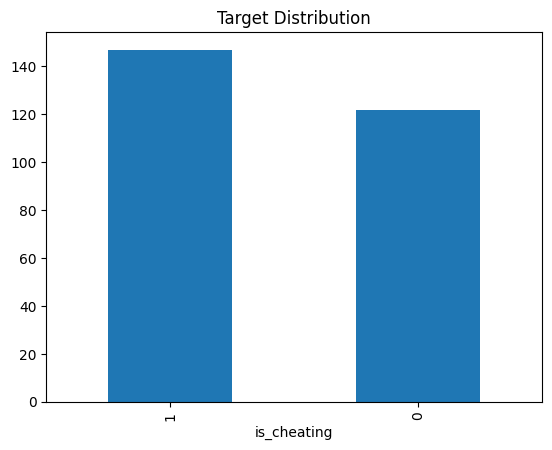

In [3]:
print(train['is_cheating'].value_counts())
train['is_cheating'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.show()

In [4]:
print(f"Unique topics: {train['topic'].nunique()}")
train['topic'].value_counts().head(10)

Unique topics: 268


topic
Fiction                                                                                                   2
The Unlikely Comeback of Analog Billboards in Smart Cities                                                1
Social Media - Connect Us                                                                                 1
The influence of weather on famous military blunders                                                      1
Secret Menus: The Quiet Weapon of Fast Food Chains                                                        1
A postman working the midnight shift starts delivering letters for people who died years ago.             1
Travel blog content creation                                                                              1
A child stumbles upon a locked garden where time passes differently for every plant.                      1
The social lives of octopuses: intelligence in invertebrates                                              1
Having a picnic with g

In [5]:
train['text_len'] = train['answer'].str.len()
train['word_count'] = train['answer'].str.split().str.len()

train.groupby('is_cheating')[['text_len', 'word_count']].mean()


,text_len,word_count
is_cheating,,
0,1080.106557,190.147541
1,1030.598639,156.952381


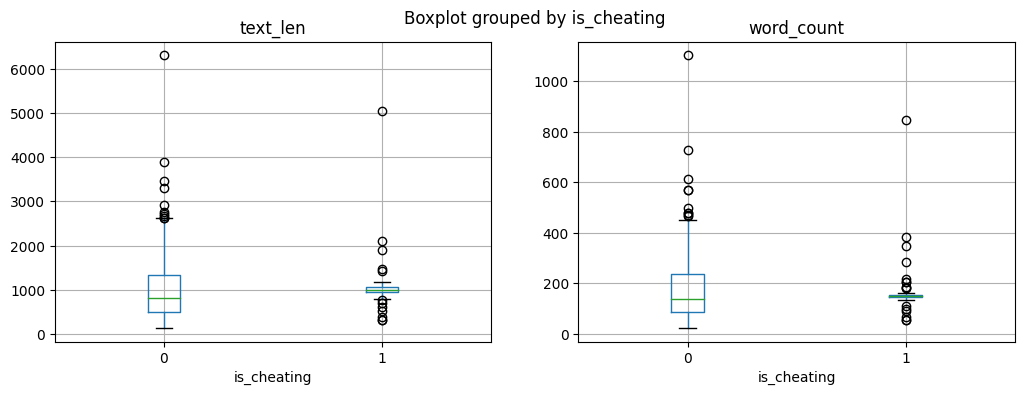

AUTHENTIC:
Robot Butlers in the year of 2025. What are they, what do they do, and where can you get one?

In this short article, we bring the future into the present and review the top 6 AI robot butlers available on the market in 2025 and go through the top brands, models, their cost, and where you can buy on

AI-GENERATED:
My eyes flew open, and the air around me feels colder than it should. For a moment I'm not sure where I am. I can still smell the sea air, and feel the icy rain blasting agains my face. He had been there beside me, sharp blue eyes, and long hair blowing in the storm. 

I blink again and wrap my blan


In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train.boxplot(column='text_len', by='is_cheating', ax=ax[0])
train.boxplot(column='word_count', by='is_cheating', ax=ax[1])
plt.show()

# %% [code]
# Örnek yazılar
print("AUTHENTIC:")
print(train[train['is_cheating']==0].iloc[0]['answer'][:300])
print("\nAI-GENERATED:")
print(train[train['is_cheating']==1].iloc[0]['answer'][:300])

In [7]:
# %% [code]
# Kolonları incele
print("=== TRAIN COLUMNS ===")
print(train.columns.tolist())
print(f"\nTrain info:")
train.info()

print("\n=== TEST COLUMNS ===")
print(test.columns.tolist())
print(f"\nTest info:")
test.info()

# Missing values
print("\n=== MISSING VALUES ===")
print("Train:", train.isnull().sum().sum())
print("Test:", test.isnull().sum().sum())

=== TRAIN COLUMNS ===
['id', 'topic', 'answer', 'is_cheating', 'text_len', 'word_count']

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           269 non-null    object
 1   topic        269 non-null    object
 2   answer       269 non-null    object
 3   is_cheating  269 non-null    int64 
 4   text_len     269 non-null    int64 
 5   word_count   269 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 12.7+ KB

=== TEST COLUMNS ===
['id', 'topic', 'answer']

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      264 non-null    object
 1   topic   264 non-null    object
 2   answer  264 non-null    object
dtypes: object(3)
memory usage: 6.3+ KB

=== MISSING VALUES ===
Train: 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np


In [9]:
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), min_df=2)
X_train = tfidf.fit_transform(train['answer'])
X_test = tfidf.transform(test['answer'])
y_train = train['is_cheating'].values

print(f"TF-IDF shape: {X_train.shape}")

TF-IDF shape: (269, 2000)


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))


In [14]:
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    
    # LightGBM
    model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_tr, y_tr)
    
    # Predictions
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds += model.predict_proba(X_test)[:, 1] / 5
    
    score = roc_auc_score(y_val, oof_preds[val_idx])
    print(f"Fold {fold} AUC: {score:.4f}")

# Overall CV score
cv_score = roc_auc_score(y_train, oof_preds)
print(f"\n✅ Overall CV AUC: {cv_score:.4f}")

[LightGBM] [Info] Number of positive: 117, number of negative: 98
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3019
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544186 -> initscore=0.177206
[LightGBM] [Info] Start training from score 0.177206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [15]:
cv_score = roc_auc_score(y_train, oof_preds)
print(f"\n✅ Overall CV AUC: {cv_score:.4f}")


✅ Overall CV AUC: 0.9290


In [16]:
submission = pd.read_csv('/kaggle/input/mercor-ai-detection/sample_submission.csv')
submission['is_cheating'] = test_preds
submission.to_csv('submission.csv', index=False)
print("\n📤 Submission saved!")
submission.head()


📤 Submission saved!


,id,is_cheating
0,scr_81822029c661,0.282941
1,scr_52efb19e0ea9,0.990330
2,scr_8fc0f33c559e,0.083894
3,scr_bac3f5d3aa12,0.114319
4,scr_adfbe009984d,0.168746
